In [ ]:
pip install git+https://github.com/tensorflow/examples.git

In [ ]:
pip install tensorflow_datasets

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
path = 'C:/Users/cotit/OneDrive/Documentos/Academicos/Master/Ottawa University Masters/Courses/03Fall 2022/01 Advanced Machine Learning/Project/cycleGAN/03 Castles/'

In [32]:
train_monet = tf.data.Dataset.list_files(f'{path}01 Datasets/02Castles Impressionism/*.jpg')
train_sketch = tf.data.Dataset.list_files(f'{path}01 Datasets/03Sketch castles impressionism/*.jpg')

test_monet = tf.data.Dataset.list_files(f'{path}01 Datasets/01RealCastles/test/castle/*.jpg')
test_sketch = tf.data.Dataset.list_files(f'{path}01 Datasets/01RealCastles/sketches/test/*.jpg')

In [33]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Convert both images to float32 tensors
    image = tf.cast(image, tf.float32)

    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286])#,
                          #method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image):
    image = load(image)
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image):
    image = load(image)
    image = normalize(image)
    return image

In [34]:
train_monet = train_monet.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_sketch = train_sketch.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_monet = test_monet.cache().map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_sketch = test_sketch.cache().map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
test_monet

<BatchDataset element_spec=TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None)>

In [12]:
sample_monet = next(iter(train_monet))
sample_sketch = next(iter(train_sketch))
sample_monet_test = next(iter(test_monet))
sample_sketch_test = next(iter(test_sketch))

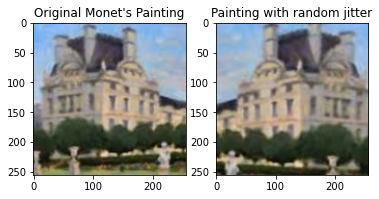

In [13]:
plt.subplot(121)
plt.title("Original Monet's Painting")
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Painting with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

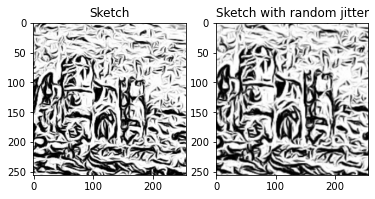

In [14]:
plt.subplot(121)
plt.title('Sketch')
plt.imshow(sample_sketch[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Sketch with random jitter')
plt.imshow(random_jitter(sample_sketch[0]) * 0.5 + 0.5)

## Import pix2pix

In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Let's use the generators just as a test without any training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


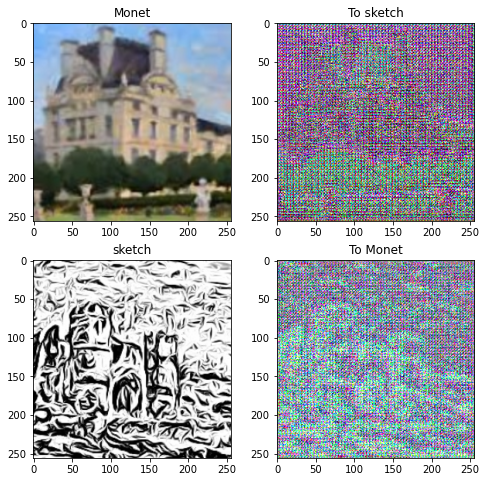

In [16]:
to_sketch = generator_g(sample_monet)
to_monet = generator_f(sample_sketch)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_monet, to_sketch, sample_sketch, to_monet]
title = ['Monet', 'To sketch', 'sketch', 'To Monet']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

Now let's test the discriminator as-is, without any training and check which parts of the image, it thinks is good

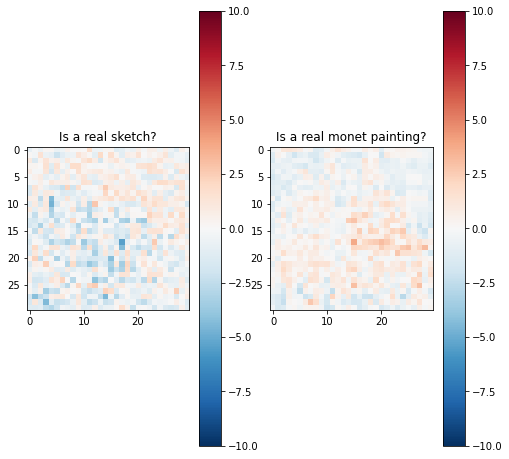

In [17]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real sketch?')
plt.imshow(discriminator_y(sample_sketch)[0, ..., -1], vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar()

plt.subplot(122)
plt.title('Is a real monet painting?')
plt.imshow(discriminator_x(sample_monet)[0, ..., -1], vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar()

plt.show()

## Loss functions

In [18]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Training

In [19]:
EPOCHS = 40

def generate_images(model, test_input, cont):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    string = f'{path}03 Predictions/01 CycleGAN training prediction impressionist castles/epoch'+str(cont)+'.jpg'
    plt.savefig(string)
    plt.show()

In [20]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_monet, train_sketch)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_f, sample_sketch, epoch)

    #if (epoch + 1) % 1 == 0:
        #ckpt_save_path = ckpt_manager.save()
        #print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         #ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
sample_monet = next(iter(test_monet))
sample_sketch2 = next(iter(test_sketch))

In [28]:
def predict_images(model, test_input, cont):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    string = f'{path}03 Predictions/02 CycleGAN prediction impressionist castles 100 epochs/cycleGAN_Castle_prediction_100Epochs{cont}.jpg'
    plt.savefig(f"cycleGAN_Castle_prediction_100Epochs{cont}.jpg")
    plt.show()

In [27]:
%pwd

'C:\\Users\\cotit\\OneDrive\\Documentos\\Academicos\\Master\\Ottawa University Masters\\Courses\\03Fall 2022\\01 Advanced Machine Learning\\Project\\cycleGAN\\03 Castles\\02Models'

In [ ]:
# Run the trained model on the test dataset
cont = 840
for inp in test_sketch.take(500):
    cont = cont +1
    predict_images(generator_f, inp, cont)

### Save the generator models

In [ ]:
generator_f.save_weights('generator_f_castles', save_format='tf')

In [ ]:
generator_g.save_weights('generator_g_castles', save_format='tf')

In [23]:
# Cargue el estado del modelo anterior.
generator_f.load_weights('generator_f_castles')

## Test the generator on test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


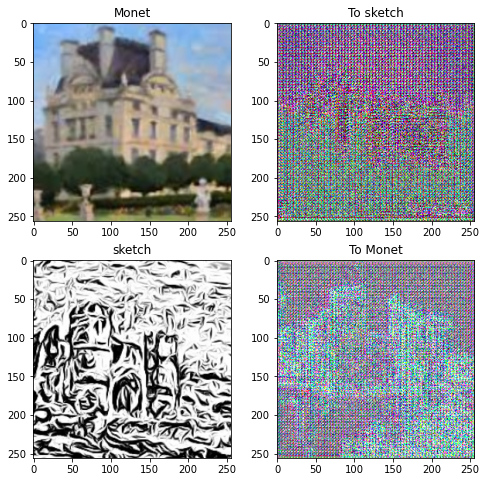

In [22]:
to_sketch = generator_g(sample_monet_test)
to_monet = generator_f(sample_sketch_test)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_monet, to_sketch, sample_sketch, to_monet]
title = ['Monet', 'To sketch', 'sketch', 'To Monet']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()